**Trabalho Final da disciplina Computação em Nuvem**

**Discente**

*   **Valéria Cristina A. R. de Figueredo -- vcarf@cesar.school**

**Docente: Pedro Silveira Pisa**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Sobre o Trabalho Final e os Dados**


**Objetivo do trabalho:** Realizar análises em cima de filmes e séries que
estão disponíveis na Netflix. Portanto, os arquivos foram baixados e processados, bem como as questões foram resolvidas em Python (Panda e Dask).

No âmbito das nuvens, foi criado um bucket no Amazon S3, onde foram colocados os arquivos já pre-processados. Também foram construidas Tabelas no Amazon Athena que consultará os dados desse Bucket e responderá às perguntas utilizando SQL do Athena.


## Base de dados:

[base de dados 1 - filmes](https://drive.google.com/file/d/1gLsCjaMrL91ECdThq58cZAzB9tPxG18g/view?usp=sharing ) e [base de dados 2- Avaliações dos consumidores](https://drive.google.com/file/d/1C_T1w8fc7Oa8MeTo4LMTEcv90IfEOS-6/view?usp=sharing)


**Descrição das colunas:**  

**Base de dados 1 - filmes**

1. ID do filme
2. título e ano de lançamento

**Base de dados 2- Avaliações dos Consumidores**

1. Cust_Id: ID do customer que fez a avaliação
2. Rating: avaliação (nota)
3. Date: data da avaliação
4. Movie_Id: ID do filme

## Sobre as questões

**Queries utilizadas para responder às seguintes perguntas:**


1. Quantos filmes estão disponíveis no dataset?
2. Qual é o nome dos 5 filmes com melhor média de avaliação?
3. Quais os 9 anos com menos lançamentos de filmes?
4. Quantos filmes que possuem avaliação maior ou igual a 4.7, considerando apenas os filmes avaliados na última data de avaliação do dataset?
5. Quais os id's dos 5 customers que mais avaliaram filmes e quantas avaliações cada um fez?

## Forma de resolução

**Documentação**

1. Explicação do passo a passo necessário para rodar o código
2. Print mostrando os dados no bucket do Amazon S3
3. Print do Amazon Athena com a query executada e a resposta obtida


**Compartilhar o trabalho em um Documento (Google Docs, Word ou similar)**

Será no prório COLAB, onde estão os códigos, as análises e alguns prints das consultas no banco de dados.

**Tecnologias a serem utilizadas**

● Amazon S3
● Amazon Athena
● SQL
● Python

## ----------------------

# **1. Bibliotecas**

In [ ]:
import pandas as pd
!pip install pyarrow

# **2. Análise Exploratória**

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/cloud/movies.csv')
df1.head()

,1;(Dinosaur Planet,2003)
0,2;(Isle of Man TT 2004 Review,2004)
1,3;(Character,1997)
2,4;(Paula Abdul's Get Up & Dance,1994)
3,5;(The Rise and Fall of ECW,2004)
4,6;(Sick,1997)


In [ ]:
# Verifique os nomes das colunas
print(df1.columns)

Index(['1;(Dinosaur Planet', ' 2003)'], dtype='object')


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/cloud/customers_rating.csv')
df2.head()

,Cust_Id;Rating;Date;Movie_Id
0,1488844;3.0;2005-09-06;1
1,822109;5.0;2005-05-13;1
2,885013;4.0;2005-10-19;1
3,30878;4.0;2005-12-26;1
4,823519;3.0;2004-05-03;1


In [ ]:
print(df2.size)

24053764


Devido ao grande tamanho desse arquivo, será utilizada a biblioteca dask.

In [ ]:
# Verifique os nomes das colunas para identificar a coluna correta
print(df2.columns)

Index(['Cust_Id;Rating;Date;Movie_Id'], dtype='object')


# **3. Tratamento dos dados**

**3.1. Primeiro Dataset (df1)- filmes**

In [ ]:
# Etapa 1: colocar a "coluna" como a primeira linha
df1.loc[-1] = df1.columns  # mover o header para a primeira linha
df1.index = df1.index + 1  # ajustar índices
df1 = df1.sort_index()     # reordenar corretamente

# Etapa 2: unir as duas colunas em uma única string por linha
df1['merged'] = df1.iloc[:, 0].astype(str).str.strip() + '\t' + df1.iloc[:, 1].astype(str).str.strip()

# Etapa 3: aplicar a limpeza e separação
def parse_row(row):
    id_part, rest = row.split(';', 1)
    rest = rest.lstrip('(')
    name_part, year = rest.rsplit('\t', 1)
    year = year.strip(')')
    return int(id_part), name_part.strip(), int(year)

parsed_data = df1['merged'].apply(parse_row)

# Etapa 4: criar o novo DataFrame limpo
df_clean = pd.DataFrame(parsed_data.tolist(), columns=['ID', 'Nome', 'Ano'])

print(df_clean)


        ID                                            Nome   Ano
0        1                                 Dinosaur Planet  2003
1        2                      Isle of Man TT 2004 Review  2004
2        3                                       Character  1997
3        4                    Paula Abdul's Get Up & Dance  1994
4        5                        The Rise and Fall of ECW  2004
...    ...                                             ...   ...
4494  4495  Clifford: Happy Birthday Clifford / Puppy Love  2002
4495  4496                           Farewell My Concubine  1993
4496  4497                                      Texasville  1990
4497  4498                                           Gonin  2000
4498  4499                                      In My Skin  2002

[4499 rows x 3 columns]


In [ ]:
# Contagem de nomes duplicados
print(f"Número de nomes duplicados: {df_clean.duplicated(subset='Nome').sum()}")

Número de nomes duplicados: 28


In [ ]:
# Filtrar linhas com nomes duplicados
duplicados_nome = df_clean[df_clean.duplicated(subset='Nome', keep=False)]

# Ordenar para facilitar a leitura
duplicados_nome = duplicados_nome.sort_values(by='Nome')

print("Nomes duplicados e suas linhas (ID, Nome, Ano):")
print(duplicados_nome)

Nomes duplicados e suas linhas (ID, Nome, Ano):
        ID                                  Nome   Ano
2665  2666                    A Farewell to Arms  1957
1555  1556                    A Farewell to Arms  1932
4307  4308                  Beauty and the Beast  1999
3614  3615                  Beauty and the Beast  1946
62      63                            Crash Dive  1943
378    379                            Crash Dive  1996
4004  4005                             Dr. Quinn  1993
349    350                             Dr. Quinn  1993
1014  1015                             Dr. Quinn  1996
2778  2779         Dr. Seuss' The Cat in the Hat  2003
2949  2950         Dr. Seuss' The Cat in the Hat  1957
2697  2698                         Freaky Friday  1976
2579  2580                         Freaky Friday  2003
902    903                                Hamlet  2000
1504  1505                                Hamlet  1964
3217  3218                                Hamlet  1990
1330  1331       

In [ ]:
# Filtrar todas as linhas com Nome e Ano duplicados
duplicados_nome_ano = df_clean[df_clean.duplicated(subset=['Nome', 'Ano'], keep=False)]

# Ordenar para facilitar visualização
duplicados_nome_ano = duplicados_nome_ano.sort_values(by=['Nome', 'Ano'])

print("Duplicatas por Nome e Ano:")
print(duplicados_nome_ano)

Duplicatas por Nome e Ano:
        ID       Nome   Ano
349    350  Dr. Quinn  1993
4004  4005  Dr. Quinn  1993


In [ ]:
# Remove a linha com ID 4005
df_clean = df_clean[df_clean['ID'] != 4005]

print("Linha com ID 4005 removida.")

Linha com ID 4005 removida.


In [ ]:
print(df_clean[df_clean['ID'] == 4005])  # Deve retornar um DataFrame vazio

Empty DataFrame
Columns: [ID, Nome, Ano]
Index: []


In [ ]:
print("Contagem de valores nulos por coluna:")
print(df_clean.isnull().sum())

Contagem de valores nulos por coluna:
ID      0
Nome    0
Ano     0
dtype: int64


In [ ]:
# Contagem total de valores ausentes (nulos)
total_nulos = df_clean.isnull().sum().sum()
print(f"Total de valores ausentes no DataFrame: {total_nulos}")

Total de valores ausentes no DataFrame: 0


In [ ]:
# Verificar os tipos de dados
print(df_clean.dtypes)

ID       int64
Nome    object
Ano      int64
dtype: object


In [ ]:
# Verificar se os índices são únicos
print(df_clean.index.is_unique)

True


In [ ]:
# Verificar os tipos de dados de cada coluna no DataFrame
print(df_clean.dtypes)

ID       int64
Nome    object
Ano      int64
dtype: object


In [ ]:
# Resumo geral do DataFrame, incluindo tipos de dados e valores nulos
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4498 entries, 0 to 4498
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      4498 non-null   int64 
 1   Nome    4498 non-null   object
 2   Ano     4498 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 269.6+ KB
None


In [ ]:
# Resumo estatístico das colunas numéricas
print(df_clean.describe())

                ID          Ano
count  4498.000000  4498.000000
mean   2249.609827  1990.242552
std    1298.774464    16.712299
min       1.000000  1915.000000
25%    1125.250000  1985.000000
50%    2249.500000  1997.000000
75%    3373.750000  2002.000000
max    4499.000000  2005.000000


**3.2. Segundo Dataset (df2)-Avaliações dos Consumidores**

In [ ]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24053764 entries, 0 to 24053763
Data columns (total 1 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Cust_Id;Rating;Date;Movie_Id  object
dtypes: object(1)
memory usage: 183.5+ MB
None


In [ ]:
import dask.dataframe as dd

# Caminho para o arquivo original
arquivo_origem = '/content/drive/MyDrive/cloud/customers_rating.csv'

# Tipos de dados otimizados
dtypes = {
    'Cust_Id': 'int32',
    'Rating': 'int8',
    'Movie_Id': 'int16'
}

# Ler o arquivo CSV com Dask
df_dask = dd.read_csv(
    arquivo_origem,
    sep=';',
    dtype=dtypes,
    parse_dates=['Date'],
    assume_missing=True  # bom para tipos mistos
)

# Visualizar rapidamente
print(df_dask.head())

# Salvar em formato Parquet particionado
df_dask.to_parquet(
    'dados_parquet_dask',
    engine='pyarrow',
    compression='snappy',
    write_index=False
)

   Cust_Id  Rating       Date  Movie_Id
0  1488844       3 2005-09-06         1
1   822109       5 2005-05-13         1
2   885013       4 2005-10-19         1
3    30878       4 2005-12-26         1
4   823519       3 2004-05-03         1


In [ ]:
#Verificação de duplicadas
# Agrupar pelas colunas e contar quantas vezes cada combinação aparece
contagens = df_dask.groupby(['Cust_Id', 'Rating', 'Movie_Id', 'Date']).size()

# Filtrar onde a contagem for maior que 1 → são duplicados
duplicatas = contagens[contagens > 1].compute()

print("Duplicatas encontradas:")
print(duplicatas)

Duplicatas encontradas:
Series([], dtype: int64)


In [ ]:
df_dask[df_dask['Movie_Id'] == 4005].compute()

,Cust_Id,Rating,Date,Movie_Id
2128668,1753259,4,2005-07-21,4005
2128669,1294425,3,2005-08-17,4005
2128670,173183,5,2004-09-07,4005
2128671,1945809,4,2004-12-09,4005
2128672,1296163,4,2005-01-19,4005
...,...,...,...,...
2130044,2120461,4,2003-10-22,4005
2130045,2502877,5,2004-09-26,4005
2130046,2151468,1,2005-05-14,4005
2130047,2480287,4,2005-05-25,4005


In [ ]:
# 1. Remover avaliações do df_dask onde Movie_Id = 4005 (filme e ano duplicado no df1 filmes)
df_dask_sem_filme_4005 = df_dask[df_dask['Movie_Id'] != 4005]

# Verificando os resultados
print("Avaliações restantes após remover Movie_Id = 4005:")
print(df_dask_sem_filme_4005.head())

Avaliações restantes após remover Movie_Id = 4005:
   Cust_Id  Rating       Date  Movie_Id
0  1488844       3 2005-09-06         1
1   822109       5 2005-05-13         1
2   885013       4 2005-10-19         1
3    30878       4 2005-12-26         1
4   823519       3 2004-05-03         1


# **4. Questões - Resolução com Python (Pandas e Dask)**

**1. Quantos filmes estão disponíveis no dataset?**

In [ ]:
# Contar o número de filmes no dataset
numero_de_filmes = df_clean.shape[0]
print(f"Total de filmes no dataset: {numero_de_filmes}")

Total de filmes no dataset: 4498


**2. Qual é o nome dos 5 filmes com melhor média de avaliação?**

In [ ]:
# 1. Calcular a média das avaliações por Movie_Id
media_avaliacao = df_dask_sem_filme_4005.groupby('Movie_Id')['Rating'].mean()

# 2. Ordenar pela média decrescente e pegar os 5 primeiros
top_5_medias = media_avaliacao.nlargest(5)

# 3. Converter para Pandas (está em Dask Series)
top_5_medias = top_5_medias.compute()

# 4. Obter os IDs dos top 5 filmes
top_5_ids = top_5_medias.index.tolist()

# 5. Buscar os nomes no df_clean (onde ID corresponde ao Movie_Id)
top_5_nomes = df_clean[df_clean['ID'].isin(top_5_ids)][['ID', 'Nome', 'Ano']]

# 6. Juntar com a média de avaliação
resultado_final = top_5_nomes.merge(top_5_medias.rename("Média"), left_on='ID', right_index=True)

# 7. Ordenar o resultado pela média
resultado_final = resultado_final.sort_values(by='Média', ascending=False)

# Mostrar o resultado
print("Top 5 filmes com melhor média de avaliação:")
print(resultado_final)

Top 5 filmes com melhor média de avaliação:
        ID                                               Nome   Ano     Média
3455  3456                                     Lost: Season 1  2004  4.670989
3032  3033   Ghost in the Shell: Stand Alone Complex: 2nd Gig  2005  4.586364
2101  2102                             The Simpsons: Season 6  1994  4.581296
4237  4238                                          Inu-Yasha  2000  4.554434
12      13  Lord of the Rings: The Return of the King: Ext...  2003  4.552000


**3. Quais os 9 anos com menos lançamentos de filmes?**


In [ ]:
# Contar quantos filmes foram lançados por ano
contagem_por_ano = df_clean['Ano'].value_counts()

# Ordenar do menor para o maior e pegar os 9 menores anos
anos_com_menos_filmes = contagem_por_ano.sort_values().head(9)

print("9 anos com menos lançamentos de filmes:")
print(anos_com_menos_filmes)

9 anos com menos lançamentos de filmes:
Ano
1915    1
1926    1
1922    1
1917    1
1929    2
1916    2
1931    2
1918    2
1924    2
Name: count, dtype: int64


**4. Quantos filmes que possuem avaliação maior ou igual a 4.7, considerando apenas os filmes avaliados na última data de avaliação do dataset?**

In [ ]:
# 1. Última data
ultima_data =  df_dask_sem_filme_4005['Date'].max().compute()

# 2. Avaliações na última data e com rating >= 4.7
avaliacoes_validas =  df_dask_sem_filme_4005[(df_dask_sem_filme_4005['Date'] == ultima_data) & (df_dask_sem_filme_4005['Rating'] >= 4.7)]

# 3. Filmes distintos com ao menos uma avaliação >= 4.7
filmes_top = avaliacoes_validas['Movie_Id'].nunique().compute()

# 4. Resultado
print(f'Número de filmes com ao menos uma avaliação ≥ 4.7 na última data de avaliação ({ultima_data.date()}): {filmes_top}')


Número de filmes com ao menos uma avaliação ≥ 4.7 na última data de avaliação (2005-12-31): 779


**5. Quais os id's dos 5 customers que mais avaliaram filmes e quantas avaliações cada um fez?**

In [ ]:
# 1. Agrupar por Cust_Id e contar avaliações
contagem_avaliacoes =  df_dask_sem_filme_4005.groupby('Cust_Id').size()

# 2. Obter os 5 clientes com mais avaliações
top_5_customers = contagem_avaliacoes.nlargest(5).compute()

# 3. Mostrar o resultado
print("Top 5 clientes que mais avaliaram filmes:")
print(top_5_customers)

Top 5 clientes que mais avaliaram filmes:
Cust_Id
305344     4466
387418     4421
2439493    4194
1664010    4018
2118461    3768
dtype: int64


# **5.AWS- S3 e Athena**

**5.1 Download dos Arquivos para colocar no S3**


In [ ]:
df_clean.to_csv('df_pandas.csv', index=False)



In [ ]:
from google.colab import files
files.download('df_pandas.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
df2_dask = df_dask_sem_filme_4005
df2_dask.to_parquet("df2_dask.parquet", engine='pyarrow', compression='snappy')

# Salvar como diretório

import shutil

shutil.make_archive("df2_dask_parquet", 'zip', "df2_dask.parquet")

# Baixar no Colab

from google.colab import files

files.download("df2_dask_parquet.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**5.2 Dados no bucket do Amazon S3**


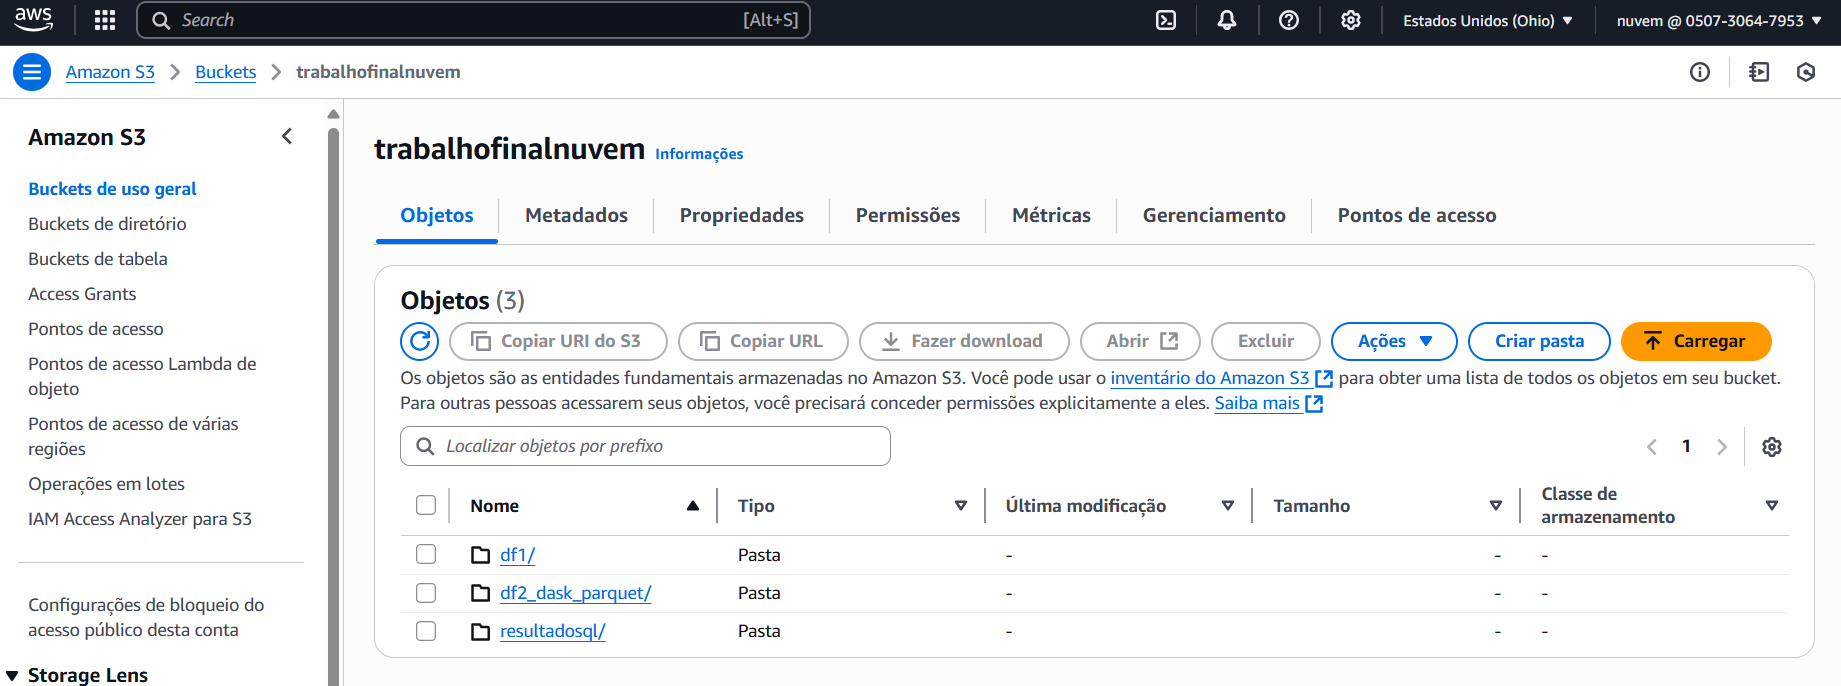

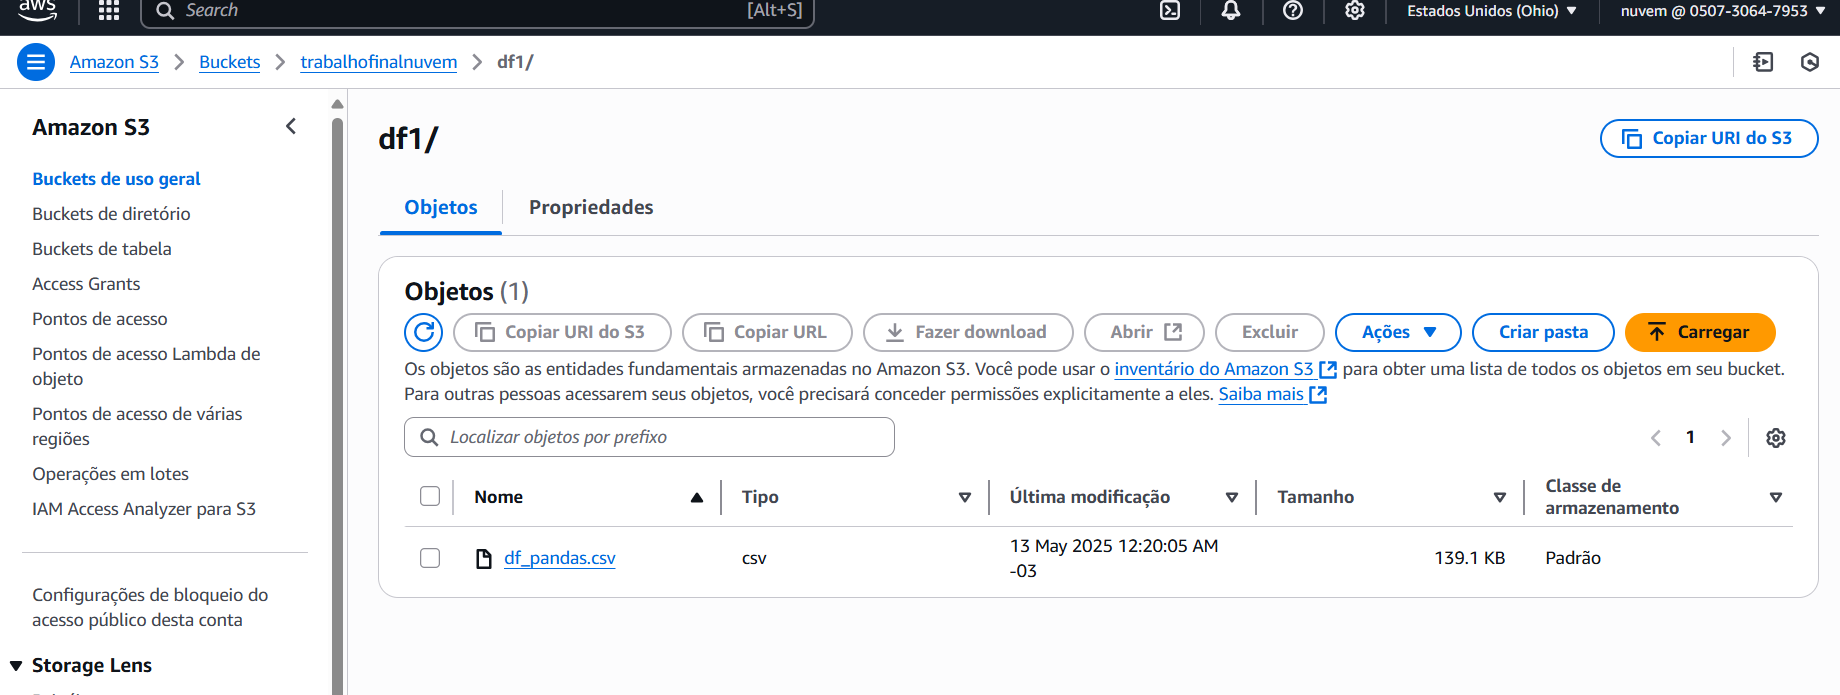

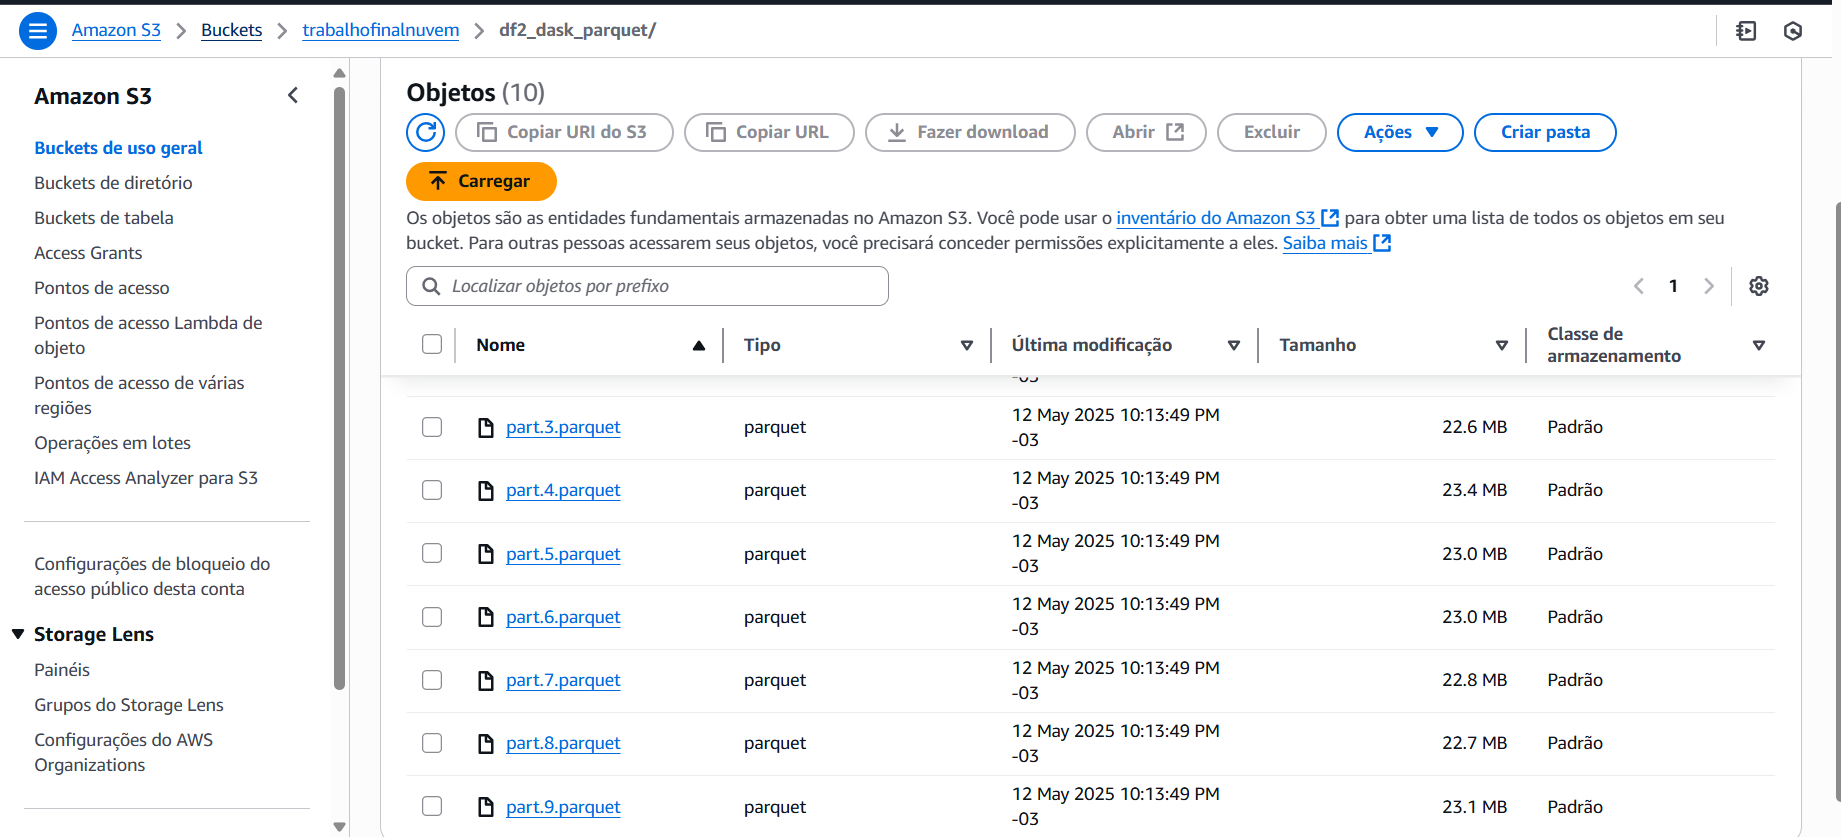

**5.3 Amazon Athena**

**Primeira Questão**

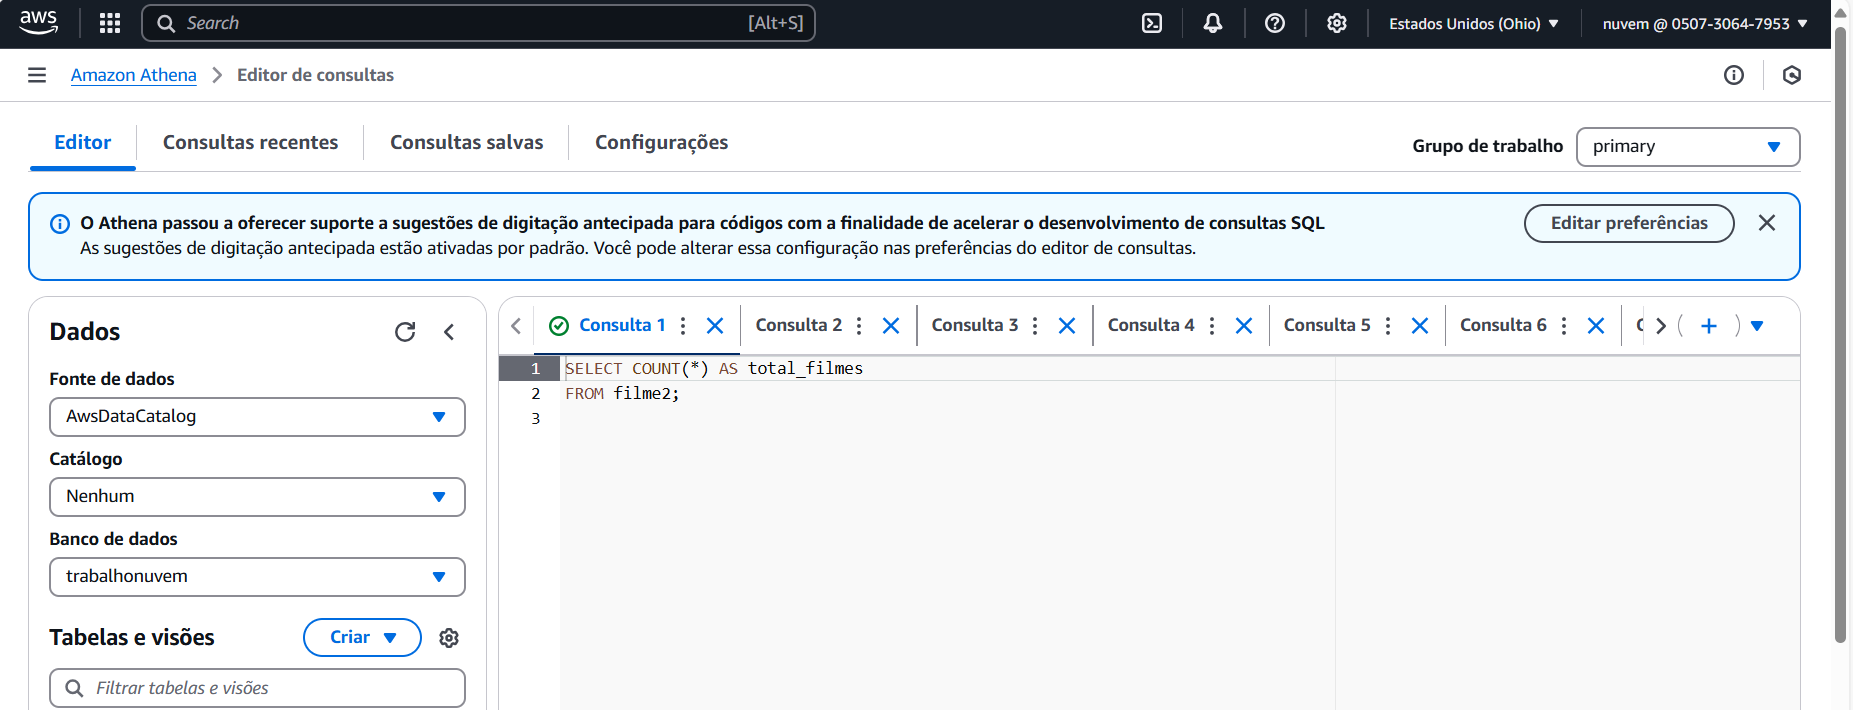

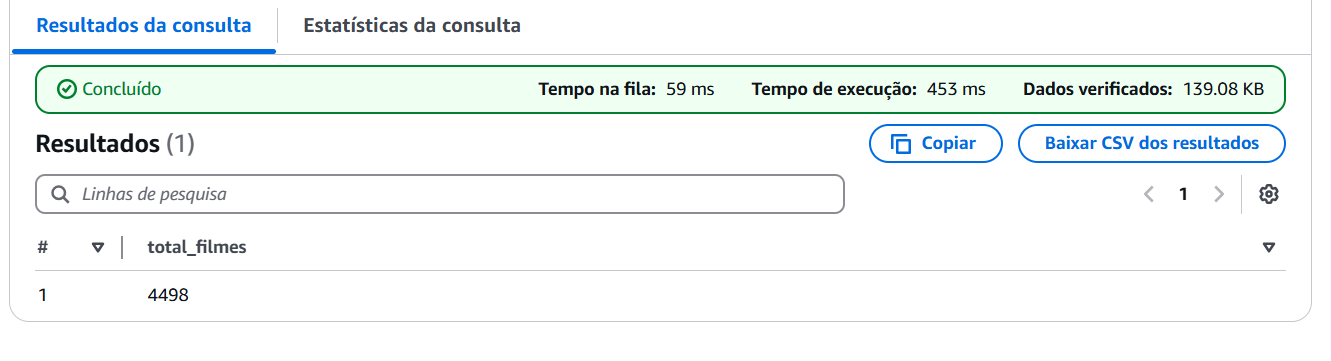

**Segunda Questão**

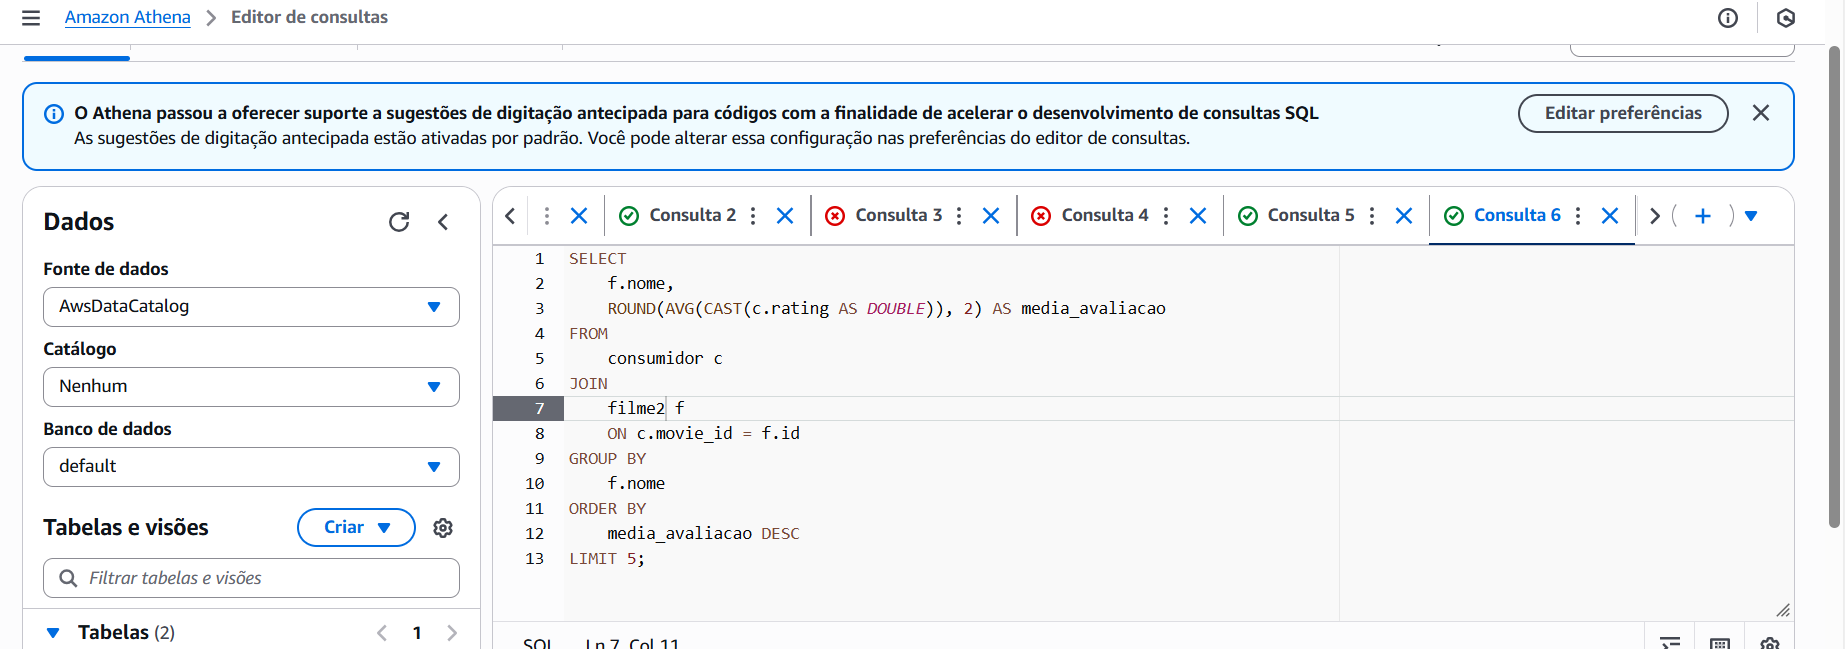

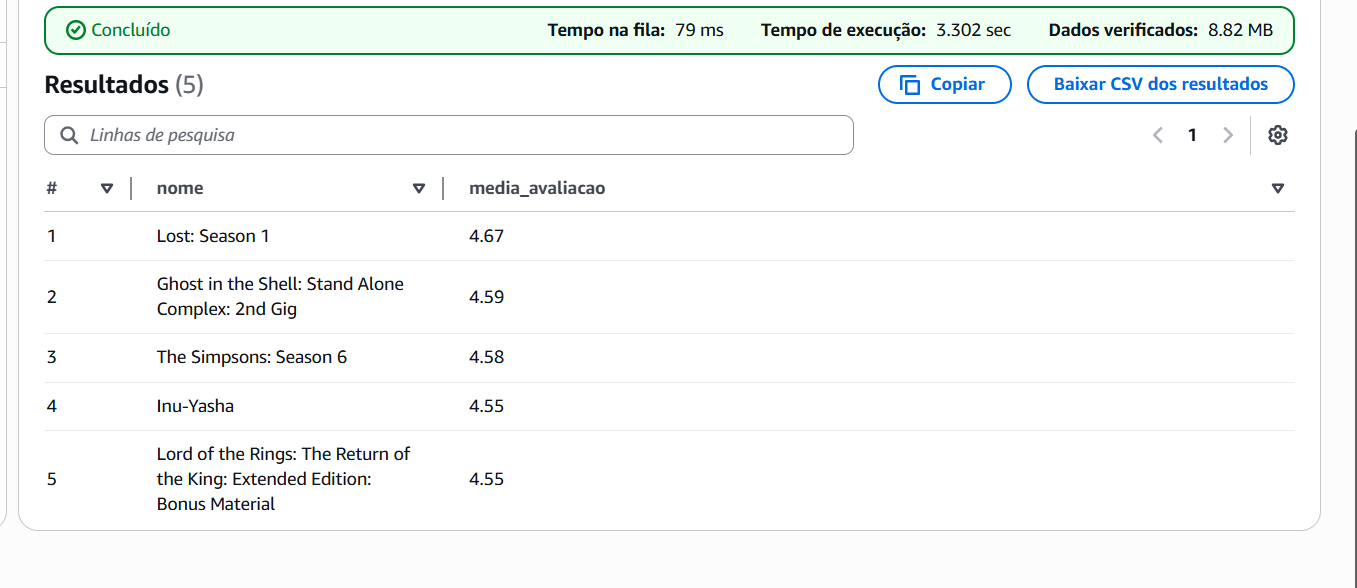

**Terceira Questão**

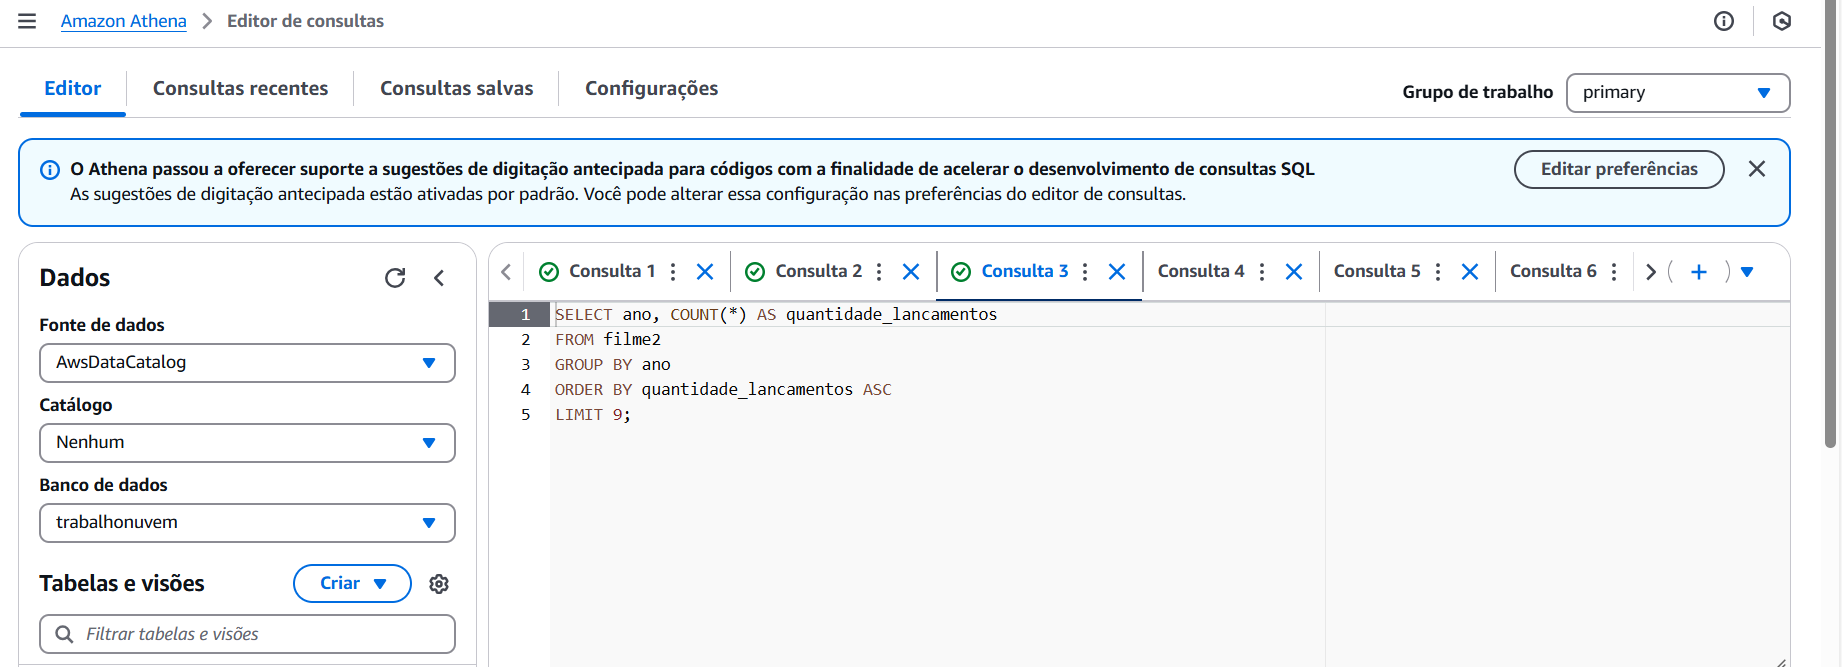

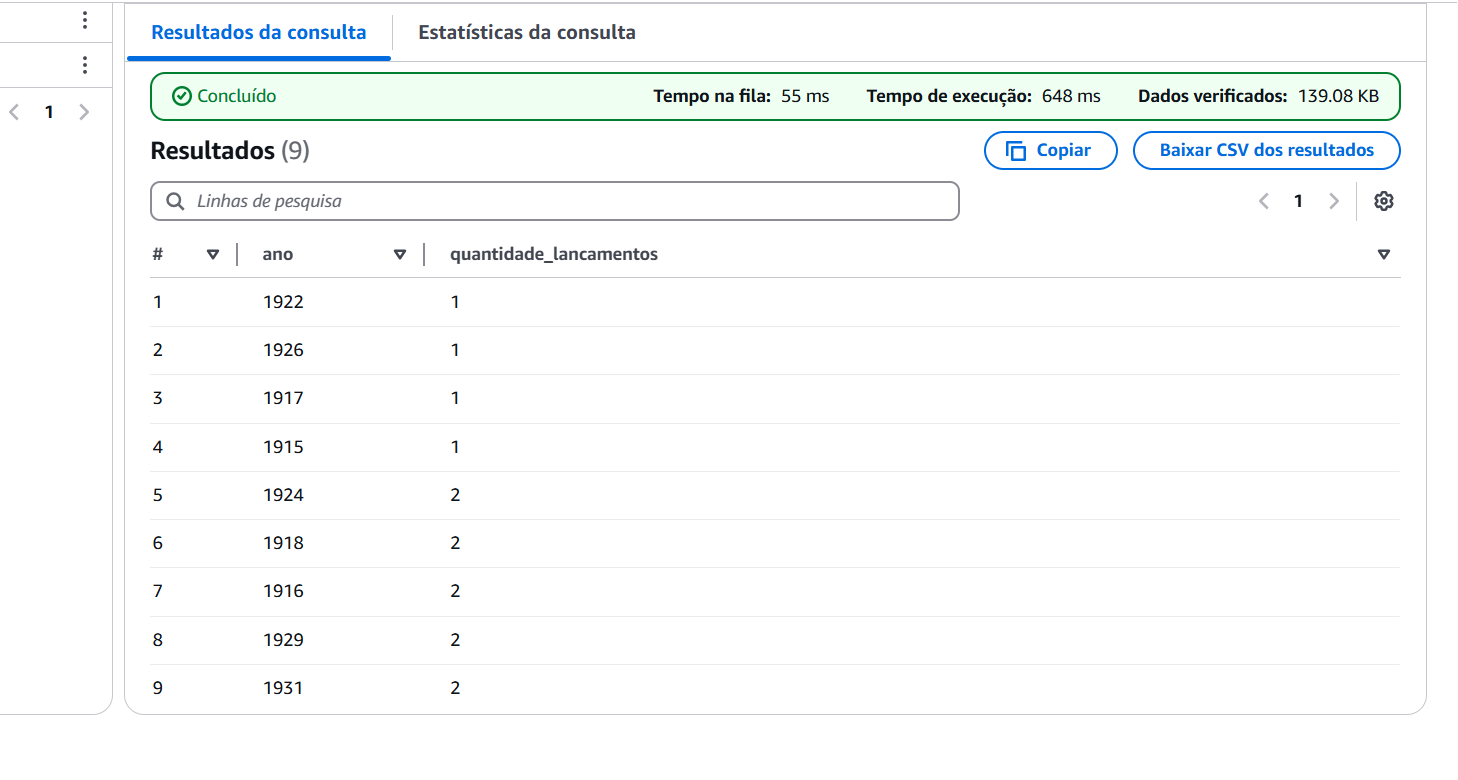

**Quarta Questão**

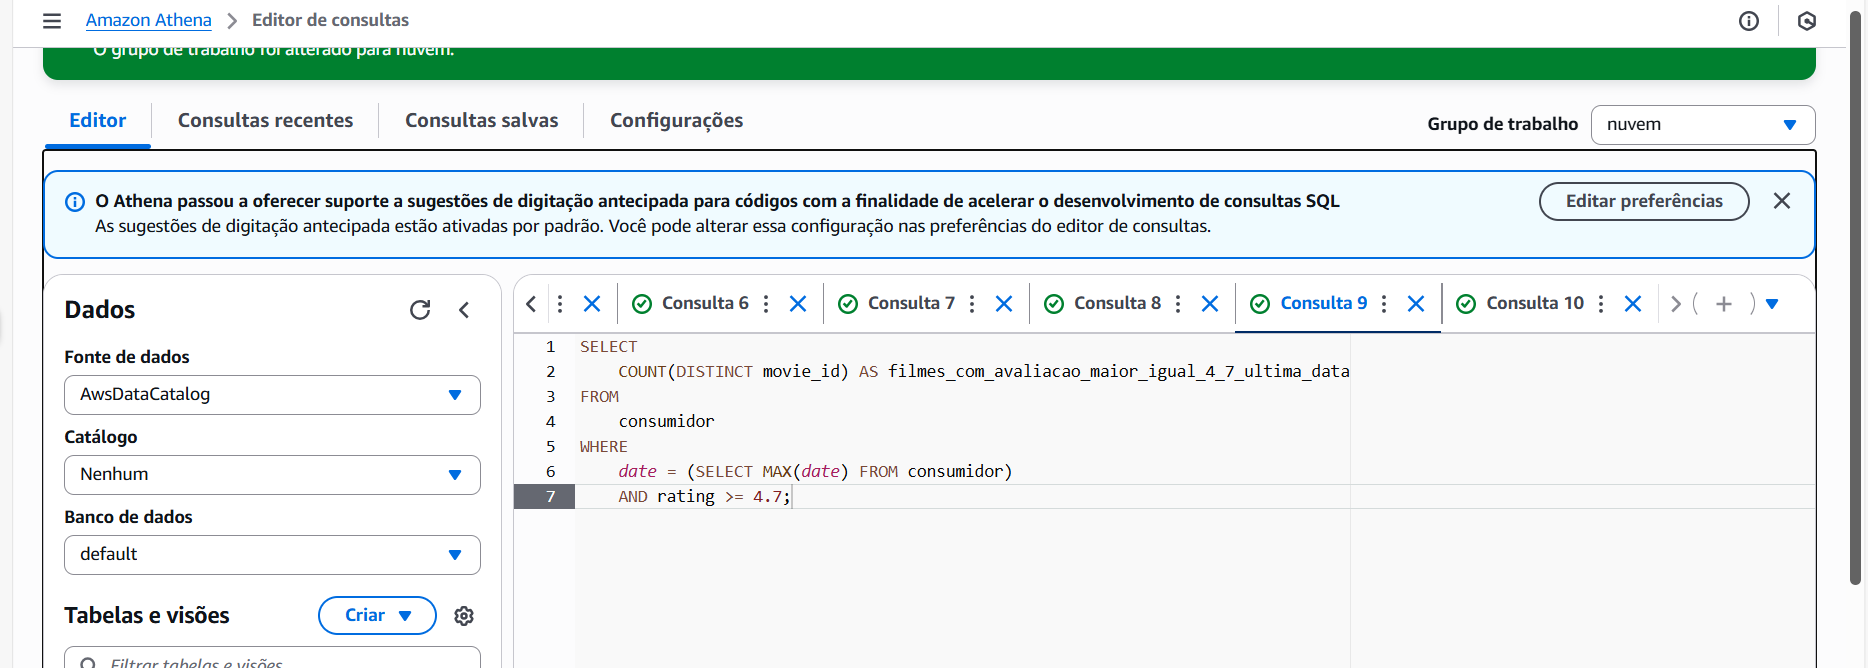

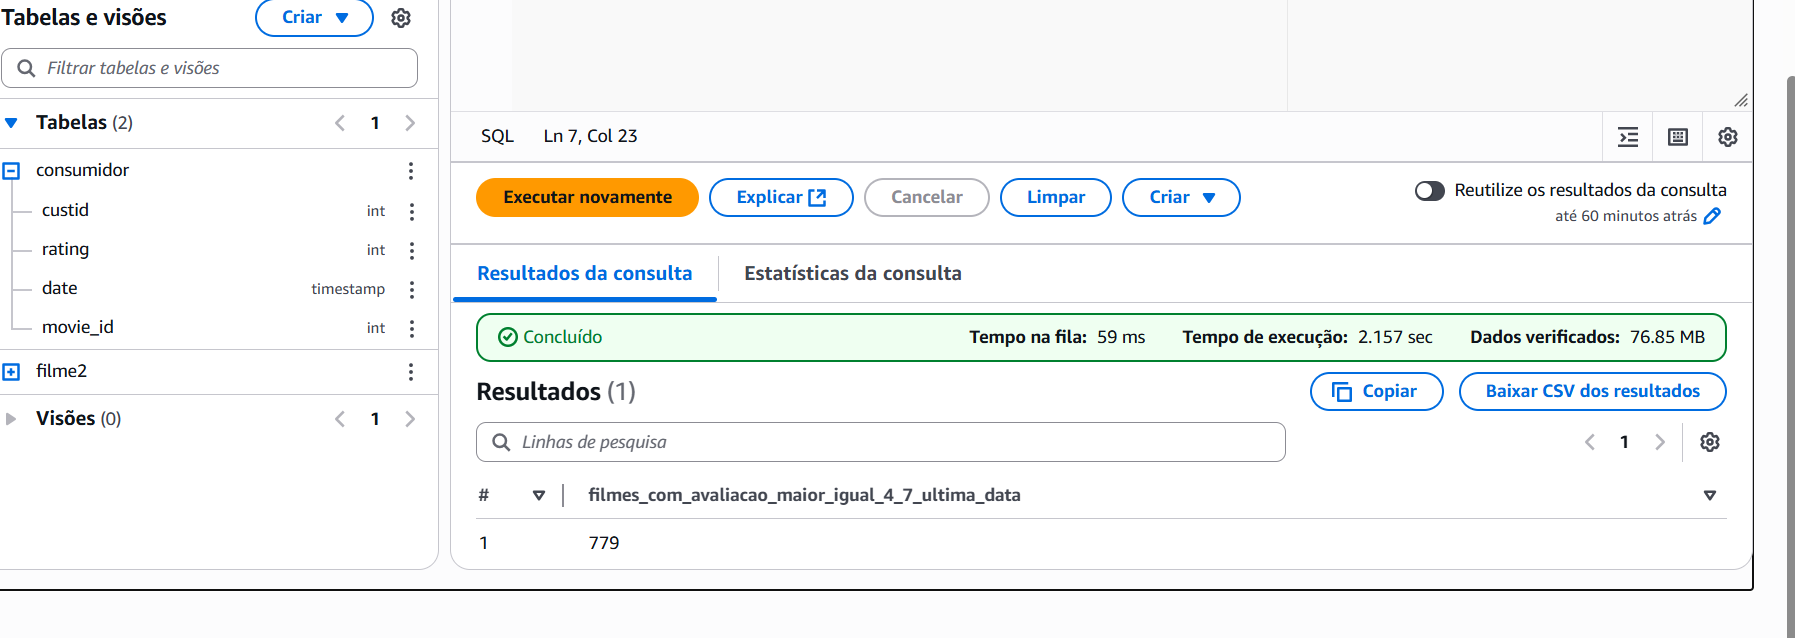

**Quinta Questão**

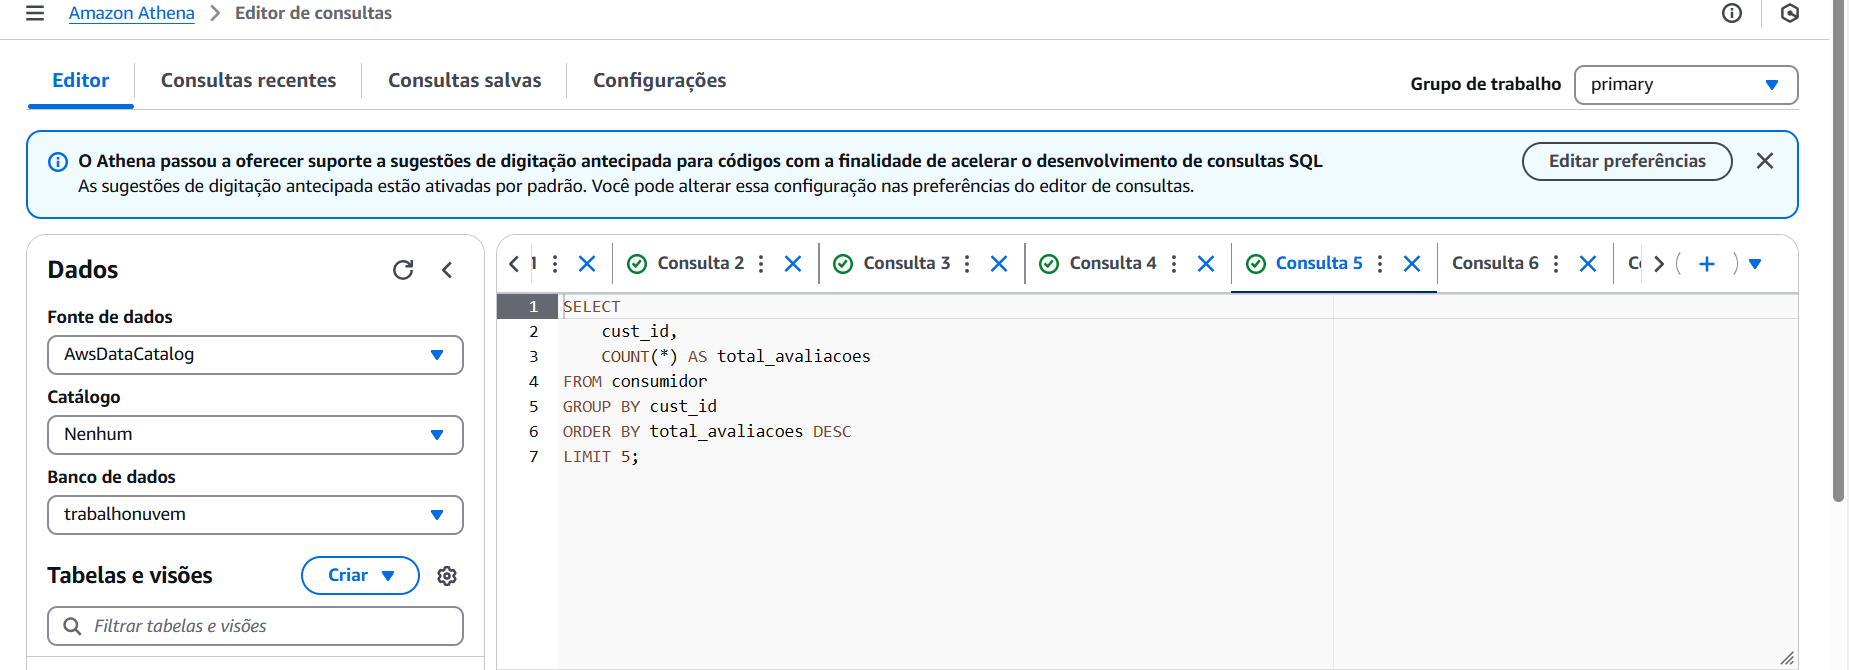

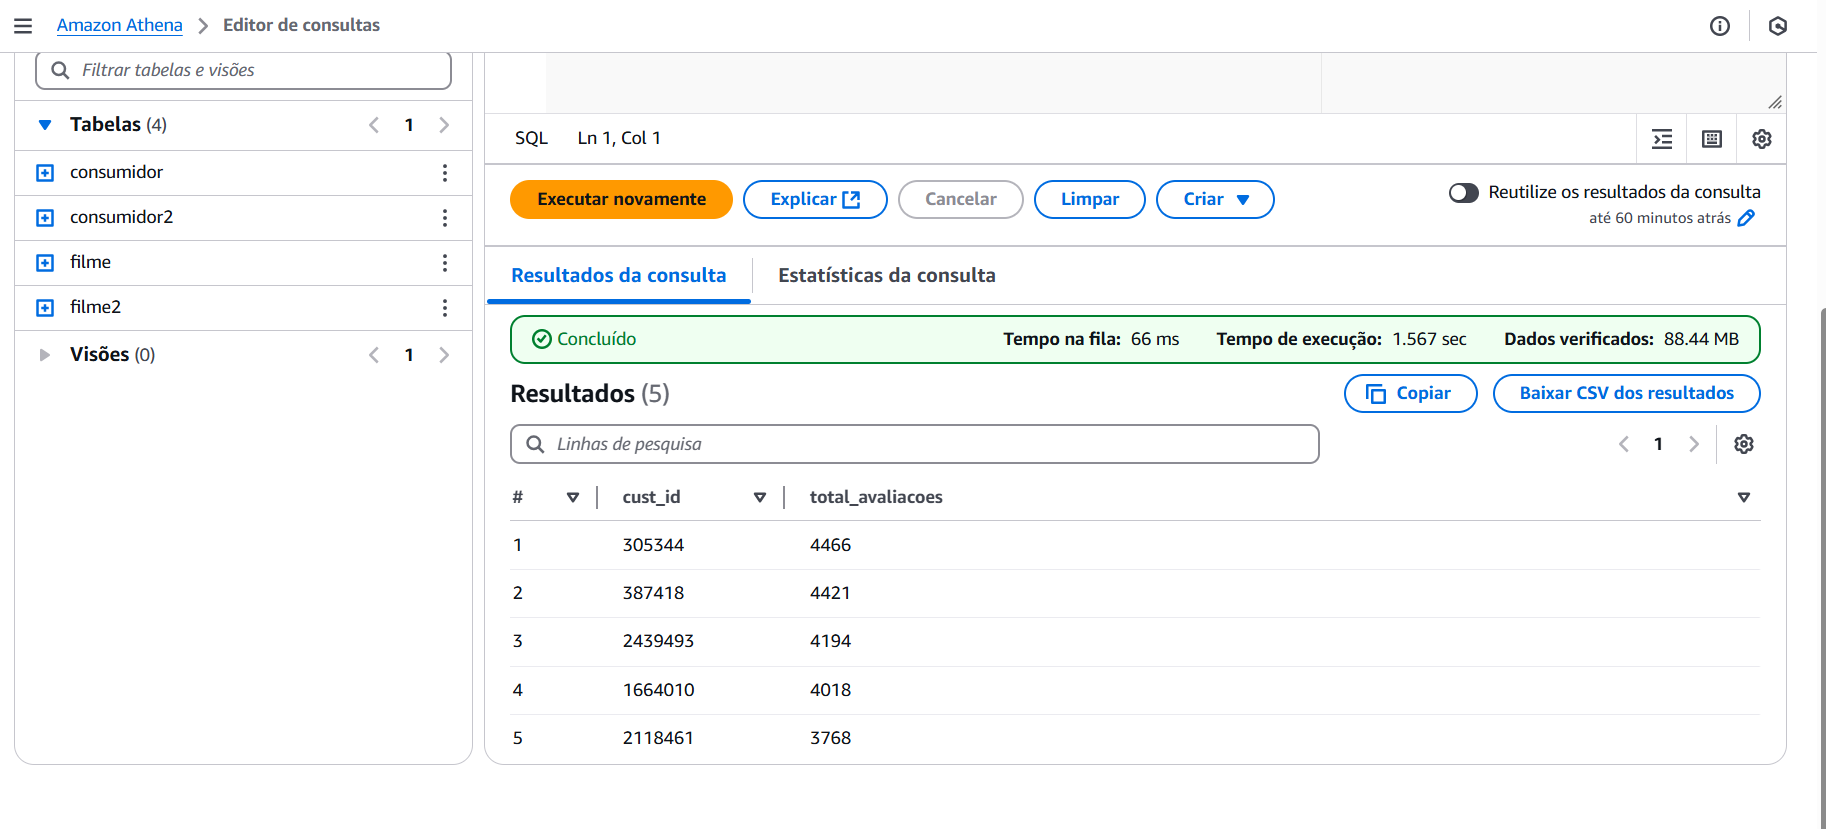

# **6. Conclusão**

O presente trabalho realizou a analise e tratamento dos dados, com a eliminação do dado duplicado - 4005 Dr. Quinn 1993 - do arquivo df1 filmes e do df2 - avaliações dos consumidores.

Em sequência, as questões foram resolvidas, utilizando Python, bibliotecas Pandas ou Dask, a depender do tamanho dos dados. As respostas foram:

**Primeira Questão:** Total de filmes no dataset: 4498;

**Segunda Questão:** Top 5 filmes com melhor média de avaliação: Lost: Season 1 2004 4.670989; Ghost in the Shell: Stand Alone Complex:2nd Gig 2005 4.586364; The Simpsons: Season 6 1994 4.581296; Inu-Yasha 2000 4.554434; e Lord of the Rings: The Return of the King: Ext...2003 4.552000;

**Terceira Questão:** 9 anos com menos lançamentos de filmes: 1915- 1, 1926-1, 1922-1, 1917-1, 1929-2, 1916-2, 1931-2, 1918-2 e 1924-2.

**Quarta Questão:** Número de filmes com ao menos uma avaliação ≥ 4.7 na última data de avaliação (2005-12-31): 779

**Quinta Questão:**Top 5 clientes que mais avaliaram filmes: ID 305344 - 4466 avaliações ; ID 387418 - 4421 avaliações; ID 2439493 - 4194 avaliações; ID 1664010 - 4018 avaliações; ID 2118461 - 3768 avaliações.

Por fim, os dados foram salvos na AWS - S3 e queries SQL foram estruturadas via Athena. As queries e respostas encontradas estão expostas acima. Para rodar os códigos, tabelas foram formuladas através da AWS Glue data catalog - tables e também com dados do bucket do S3. E foi necessário adicionar esse código na formação da tabela para pular o header e conseguir efetivar a consulta: " TBLPROPERTIES ('classification' = 'csv','skip.header.line.count' = '1');"